# COMP41680 - Marvel Vs DC Twitter Analysis

In [1]:
import tweepy
from textblob import TextBlob
from tweepy import Stream
from tweepy.streaming import StreamListener
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import oauth2
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

<img src="images/mcudc.png" style="width:600px;height:600;">

## Task 1: Identify one or more suitable web API
<p> API Chosen: </p>
- https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object  -- Tweet objecy JSON
- https://api.twitter.com/1.1/help/languages.json -- Language JSON

Famous Twitter API is used for data and sentiment analysis. Tweet object description is menthoned at <a href="https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object">link</a> 
Twitter Language API is used to get language names from their codes in Tweet object.

Tweepy package is used to collect relevant Tweets matching to a specific query.

Twitter API authentication with tokens

In [2]:
consumer_key = "dummy_key"
consumer_secret = "dummy_key"
access_token = "dummy_key"
access_token_secret = "dummy_key"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)       # Passing consumer key and secret
auth.set_access_token(access_token, access_token_secret)        # Passing access tokens
api = tweepy.API(auth)                                          # Authenticating the tokens and creating API object

## Task 2: Collect data your chosen API(s)
<b>Collecting Raw Data - Functions/Classes needed: </b>
For this assignment I have collected more than 20000 tweets of Marvel and DC fans individual. API.search() is used to collect the tweets. To avoid opening and closing file to save data I am storing it in Pandas.   :-) 


on_data() method of Listner class will be called per tweet. Pre-processing logic is implemented in on_data() method.
Preprocessed tweets are stored in Data frame one by one and at last the entire dataframe is saved to csv file. 

In [3]:
mcu_df = pd.DataFrame()              # storing MCU fan's tweets data
dceu_df = pd.DataFrame()             # storing DC fan's tweets data

In [4]:
for universe in ["@Marvel OR @Avengers", "@DCComics OR @BatmanvSuperman"]:
#for universe in ["@DCComics OR @BatmanvSuperman"]:
    id_ = 0
    top_df = pd.DataFrame()
    for i in range(850):
        public_tweets = api.search(universe , count=100, max_id=str(id_ - 1), wait_on_rate_limit=True)
        for tweet in public_tweets:
            temp_df = pd.DataFrame()
            id_ = tweet.id                                    # parsing unique id of tweet
            text = tweet.text                                 # parsing text
            favorite_count = tweet.favorite_count             # parsing favourite_count
            favorited = tweet.favorited                       # parsing favorited
            retweet_count = tweet.retweet_count               # parsing retweet_count
            lang = tweet.lang                                 # parsing language code of tweet
            retweeted = tweet.retweeted                       # parsing reweeted tweet True/False
            time_zone = tweet.user.time_zone                  # parsing user's time zone
            location = tweet.user.location                    # parsing location of user
            u_lang = tweet.user.lang                          # parsing user's language code
            hashtags = None
            if(len(tweet.entities["hashtags"]) != 0):                # block used to find hashtags of the tweets
                if( tweet.entities["hashtags"][0]["text"] != "") :
                    hashtags = tweet.entities["hashtags"][0]["text"]   # store the hastags associted with tweet

            temp_df["favorite_count"] = pd.Series(favorite_count)   # saving all fetched attributes into Dataframe
            temp_df["favorited"] = pd.Series(favorited)
            temp_df["retweet_count"] = pd.Series(retweet_count)
            temp_df["lang"] = pd.Series(lang)
            temp_df["u_lang"] = pd.Series(u_lang)
            temp_df["retweeted"] = pd.Series(retweeted)
            temp_df["time_zone"] = pd.Series(time_zone)
            temp_df["location"] = pd.Series(location)
            temp_df["hashtags"] = pd.Series(hashtags)
            temp_df["text"] = pd.Series(text)

            top_df = pd.concat([top_df, temp_df], ignore_index =True, axis = 0)         # concating the result
    print(universe)
    if(universe == "@Marvel OR @Avengers"):
        mcu_df = top_df
    elif (universe == "@DCComics OR @BatmanvSuperman"):
        dceu_df = top_df

In [5]:
api = 'https://api.twitter.com/1.1/help/languages.json'
def oauth_req(url, key, secret, http_method="GET", post_body=b"", http_headers=None):
    consumer = oauth2.Consumer(key, secret)                           # consumer authentication 
    token = oauth2.Token(access_token, access_token_secret)           # token authentication
    client = oauth2.Client(consumer, token)                           # client authentication
    resp, content = client.request(url, method=http_method, body=post_body, headers=http_headers)   # API hit using auth
    return content                                                    # returning JSON of language in binary encoding



language = oauth_req(api, bytes(consumer_key, "utf-8"), bytes(consumer_secret, "utf-8"))

## Task 3: Parse the collected data, and store it in an appropriate file format
In task #2 we have already parsed the tweet JSON and stored it in two separate dataframes namely mcu_df and dceu_df. These dataframes will be exported to the csv file for further analysis. These dataframe have redudant columns which we are not going to consider for the analysis as the most of the columns values is missing.
The JSON object retrived from twitter language API is used to create the dictionary which will be used in lambda function to update the language code by it's name under task #4

In [6]:
mcu_df.to_csv("mcu.csv", index=False)           # exporting MCU fan's data into csv excluding index of DF into csv
dceu_df.to_csv("dceu.csv", index=False)         # exporting DCEU fan's data into csv excluding index of DF into csv

In [7]:
data = json.loads(language, encoding="utf-8")  # loading JSON object with encoding of "UTF-8" 
lang_dict = {}
for d in data:
    key = d["code"]                            # language codes
    value = d["name"]                          # language descriptions
    lang_dict[key] = value                     # storing into dict as Key-Value pair

## Task 4: Load and represent the data using an appropriate data structure. Apply any pre-processing steps to clean/filter/combine the data
Most of the users don't enable GEO location so we have more missing values in location and time_zone columns. Apart from these columns there are many other columns which have more missing values and such columns are dropped from dataset because analysis on these fields will be insignificant as they don't represent sample of whole poulation.

In [8]:
mcu_df = pd.read_csv("mcu.csv", encoding='ISO-8859-1', nrows=38000)               # loading MCU fan's data 
dceu_df = pd.read_csv("dceu.csv", encoding='ISO-8859-1', nrows=38000)             # loading DC fan's data

In [9]:
mcu_df = mcu_df.loc[:][[ 'retweet_count', 'lang', 'u_lang', 'text' , "favorite_count"]]               # filtering only useful columns
dceu_df = dceu_df.loc[:][[ 'retweet_count', 'lang', 'u_lang', 'text', "favorite_count"]]             # filtering only useful columns

mcu_retweet_count = mcu_df.loc[mcu_df["retweet_count"] != 0, 'retweet_count'].sum()     # total retweets by Marvel fan's
dceu_retweet_count = dceu_df.loc[dceu_df["retweet_count"] != 0, 'retweet_count'].sum()  # total retweets by DC fan's



<b> Data filtering </b> <br>
Replacing UNDEFINED "lang" column values by "u_lang" column. Here "lang" column represents language of tweets and "u_lang" represents language of user. Then, we will store the language name from language code by using parsed lang_dict which was created under Task #3

In [10]:
print("Shape of MCU dataframe ", mcu_df.shape)
print("Shape of DCEU dataframe ", dceu_df.shape)
print("Undefined values in lang column ", mcu_df.loc[mcu_df['lang'] == "und",'lang'].count())
print("Undefined values in u_lang column ", mcu_df.loc[mcu_df['u_lang'] == "und",'u_lang'].count())

Shape of MCU dataframe  (38000, 5)
Shape of DCEU dataframe  (38000, 5)
Undefined values in lang column  1864
Undefined values in u_lang column  0


In [11]:
mcu_df.loc[mcu_df['lang'] == "und",'lang'] = mcu_df["u_lang"]
dceu_df.loc[dceu_df['lang'] == "und",'lang'] = dceu_df["u_lang"]

In [12]:
def lang(key):
    try:
        value = lang_dict[key]
    except:
        value = "English"
    return value

mcu_df["language"] = mcu_df["lang"].map(lang)            # use of lambda function to get language name for MCU fan's
dceu_df["language"] = dceu_df["lang"].map(lang)          # use of lambda function to get language name for DC fan's

<b> Finding sentiments of the tweet  </b> <br>
By use of "text" of tweets we will be calculating the polarity of tweet and if it is +ve then will say tweet is positive if it is -ve then will say tweet is negative else it is neutral. The lambda function is used to find the polarity and sentiment of the tweets. And result is stored in two new columns in dataset

In [13]:
def polarity(x):                          # used to find the polarity of the tweet by use of TextBlob package
    analysis = TextBlob(str(x))
    return analysis.sentiment.polarity
    
def pole(x):                             # used to find the sentiment of the tweets
    if x < 0:
        return "Negative"
    elif x > 0:
        return "Positive"
    else:
        return "Neutral"
    
    
mcu_df["polarity"] = mcu_df["text"].map(polarity)
mcu_df["pole"] = mcu_df["polarity"].map(pole)
dceu_df["polarity"] = dceu_df["text"].map(polarity)
dceu_df["pole"] = dceu_df["polarity"].map(pole)
mcu_df.to_csv("cleaned_mcu_df.csv", index=False)            # saving cleaned dataset to csv file of MCU fan's
dceu_df.to_csv("cleaned_dceu_df.csv", index=False)          # saving cleaned dataset to csv file of DC fan's

<b> Missing Data </b> <br>
Final Pre-Processing steps are to look for missing data to see if further pre-processing is needed.

In [14]:
display(mcu_df[mcu_df.isnull().any(axis=1)])           # select rows for which has one or more Nulls
display(dceu_df[dceu_df.isnull().any(axis=1)])         # select rows which has one or more Nulls

,retweet_count,lang,u_lang,text,favorite_count,language,polarity,pole


,retweet_count,lang,u_lang,text,favorite_count,language,polarity,pole


## Task 5: Analyse and summarise the cleaned dataset
<b> Descriptive Statistics  </b> <br>
displaying summary statistics for the MCU and DC fan's dataset

In [15]:
display(mcu_df.select_dtypes(include=[np.number]).describe())
display(mcu_df.select_dtypes(include=[np.object]).describe())
display(dceu_df.select_dtypes(include=[np.number]).describe())
display(dceu_df.select_dtypes(include=[np.object]).describe())

,retweet_count,favorite_count,polarity
count,38000.000000,38000.000000,38000.000000
mean,3203.314263,1.521079,0.224774
std,10654.497450,86.576551,0.280590
min,0.000000,0.000000,-1.000000
25%,1.000000,0.000000,0.000000
50%,168.000000,0.000000,0.136364
75%,2399.000000,0.000000,0.458333
max,152827.000000,15730.000000,1.000000


,lang,u_lang,text,language,pole
count,38000,38000,38000,38000,38000
unique,41,44,12512,27,3
top,en,en,RT @Marvel: Marvel teams up with @TheWeeknd fo...,English,Positive
freq,36098,27747,3818,36244,22473


,retweet_count,favorite_count,polarity
count,38000.000000,38000.000000,38000.000000
mean,227.600158,1.497158,0.151353
std,726.333827,28.664604,0.284456
min,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000
50%,58.000000,0.000000,0.000000
75%,216.000000,0.000000,0.341667
max,38716.000000,3184.000000,1.000000


,lang,u_lang,text,language,pole
count,38000,38000,38000,38000,38000
unique,41,42,13502,26,3
top,en,en,RT @DCComics: Who's a good super dog? #Nationa...,English,Positive
freq,36344,28714,1456,36520,17995


Plotting the histogram for numeric columns and bar plot for categorical column to understand data distribution. 

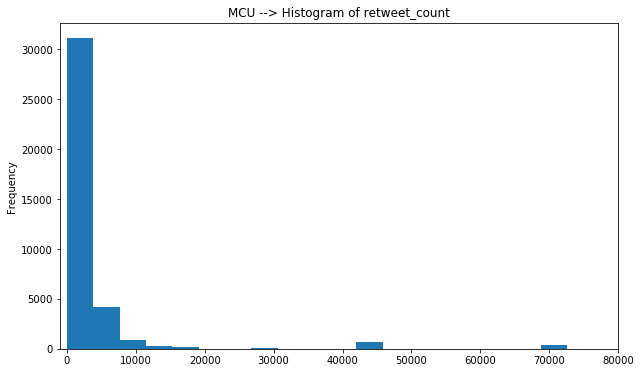

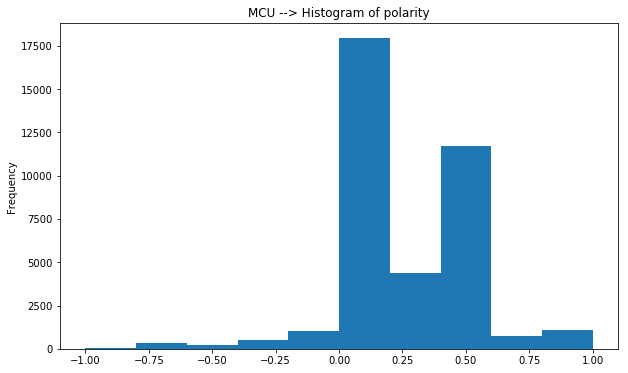

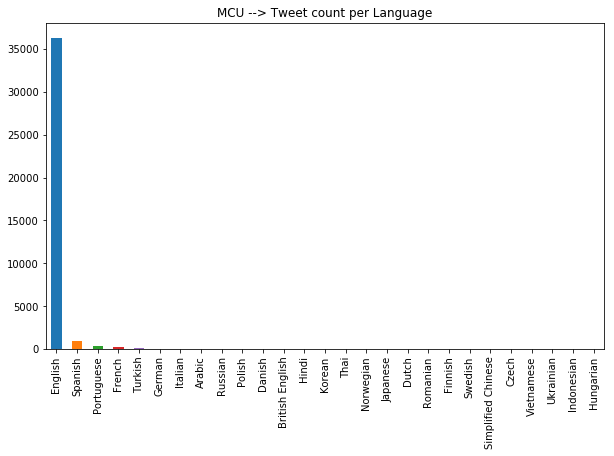

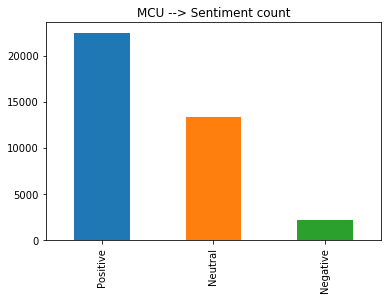

In [16]:
df = mcu_df
df["retweet_count"].plot.hist(title = "MCU --> Histogram of retweet_count", bins=40 , figsize=(10,6), xlim=(-1000,80000))
plt.show()
df["polarity"].plot.hist(title = "MCU --> Histogram of polarity" , figsize=(10,6))
plt.show()
df["language"].value_counts().plot.bar(title = "MCU --> Tweet count per Language"  , figsize=(10,6))
plt.show()
df["pole"].value_counts().plot.bar(title = "MCU --> Sentiment count")
plt.show()

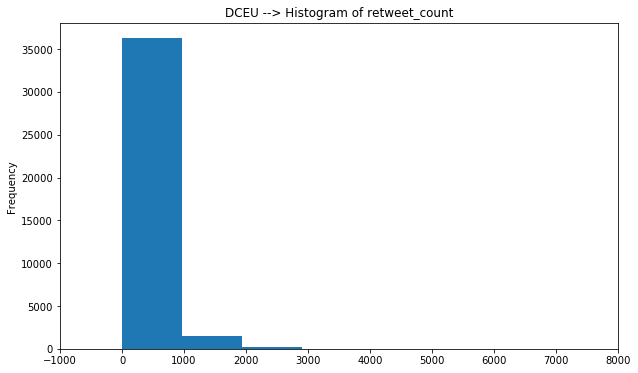

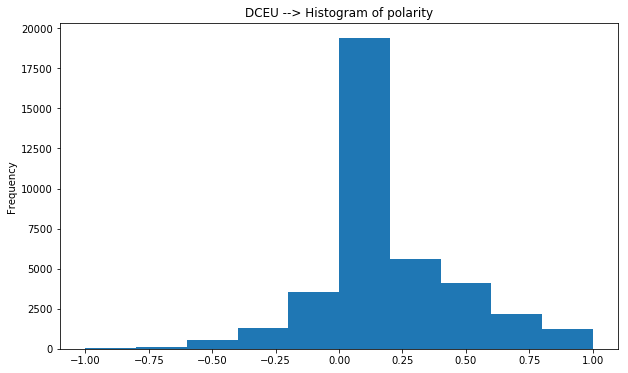

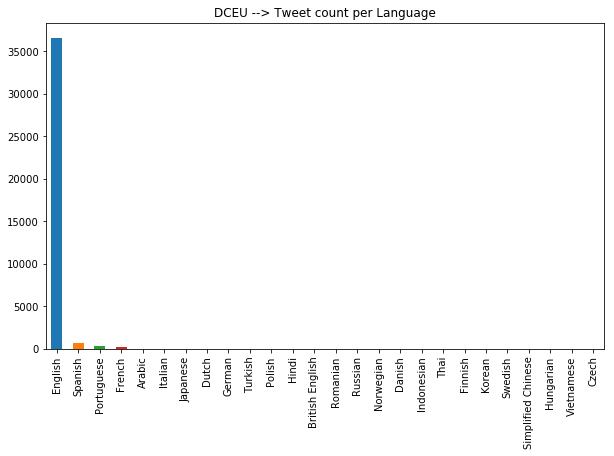

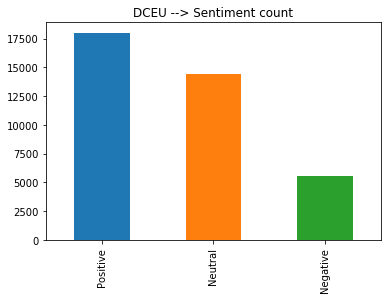

In [17]:
#df = mcu_df.loc[mcu_df['language'] != "English"]
df = dceu_df
df["retweet_count"].plot.hist(title = "DCEU --> Histogram of retweet_count", bins=40 , figsize=(10,6), xlim=(-1000, 8000))
plt.show()
df["polarity"].plot.hist(title = "DCEU --> Histogram of polarity" , figsize=(10,6))
plt.show()
df["language"].value_counts().plot.bar(title = "DCEU --> Tweet count per Language"  , figsize=(10,6))
plt.show()
df["pole"].value_counts().plot.bar(title = "DCEU --> Sentiment count")
plt.show()

<b> Note </b> <br>By plotting the data distribution we understand that vast majority of users are English. So, here distirbution of English and non English users is uneven. Also, the retweet count of the Marvel fan's tweets is too much compared to DC fan's.

<b> Matplotlib and Pandas Graphing  </b>

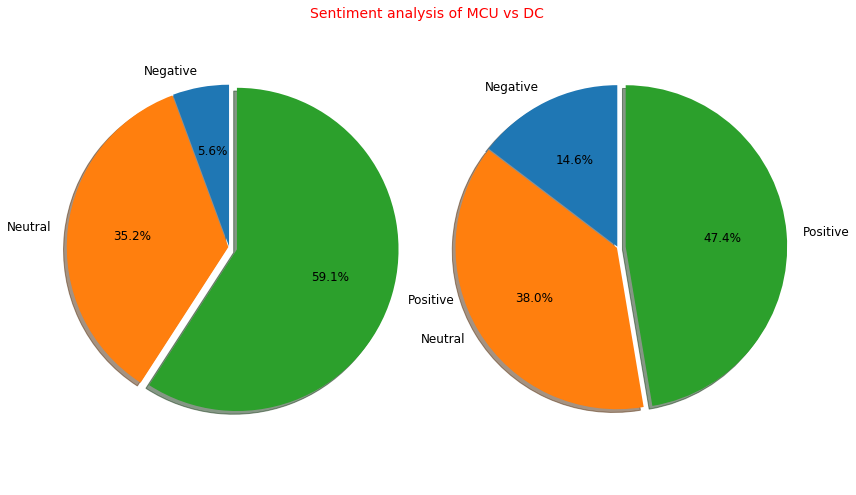

In [18]:
counts = mcu_df["pole"].value_counts().sort_index()
labels = counts.index
mcu_sizes = counts.values

counts = dceu_df["pole"].value_counts().sort_index()
dceu_sizes = counts.values

matplotlib.rcParams['font.size'] = 12.0
explode = (0.005, 0.005, 0.05) 

fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(11,7))
fig.suptitle("Sentiment analysis of MCU vs DC", fontsize=14, color="red")

ax1.pie(mcu_sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  

ax2.pie(dceu_sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')  

plt.tight_layout()
plt.show()

<b> Analysis: </b> Marvel fans tweets are more positive than DC fans.

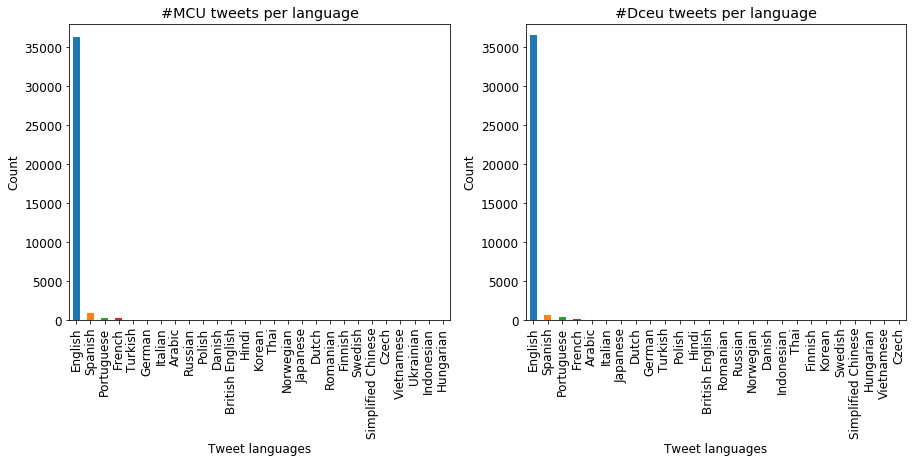

In [19]:
counts = mcu_df["language"].value_counts()
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax1.set_xlabel("Tweet languages")
ax1.set_ylabel("Count")
ax1.set_ylim((0,38000))
counts.plot(kind="bar" , title="#MCU tweets per language")

counts = dceu_df["language"].value_counts()
ax2 = fig.add_subplot(222)
ax2.set_xlabel("Tweet languages")
ax2.set_ylabel("Count")
ax2.set_ylim((0,38000))
counts.plot(kind="bar" , title="#Dceu tweets per language")

<b> Analysis: </b>  Vast majority of user are tweeting in English language

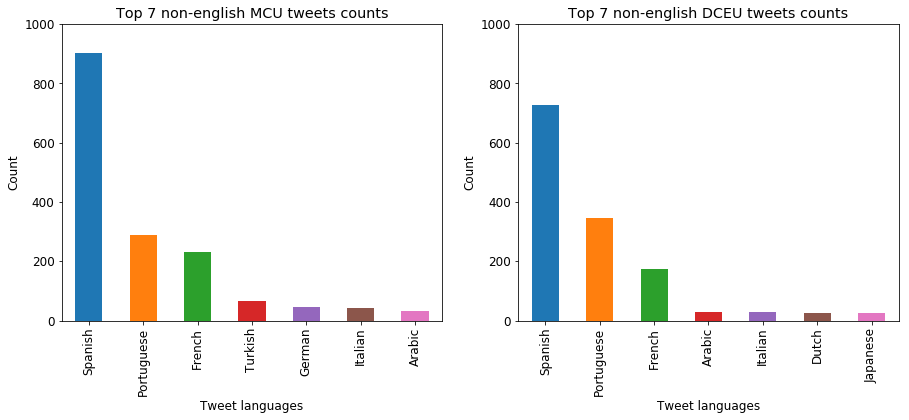

In [20]:
counts = mcu_df.loc[mcu_df['language'] != "English"]["language"].value_counts()[:7]
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax1.set_xlabel("Tweet languages")
ax1.set_ylabel("Count")
ax1.set_ylim((0,1000))
counts.plot(kind="bar" , title="Top 7 non-english MCU tweets counts")

counts = dceu_df.loc[dceu_df['language'] != "English"]["language"].value_counts()[:7]
ax2 = fig.add_subplot(222)
ax2.set_xlabel("Tweet languages")
ax2.set_ylabel("Count")
ax2.set_ylim((0,1000))
counts.plot(kind="bar" , title="Top 7 non-english DCEU tweets counts")

<b> Analysis: </b> Apart from English language users, Spanish, Portuguese and French users tweeted the most about Marvel and DC.

In [21]:
#a = pd.crosstab(mcu_df.language, mcu_df.pole)                    #alternative one line code of my entire function :-) 
def format_df_for_me(df):
    df["count"] = 1
    temp_df = df.groupby(["language", "pole"]).count()
    a = list(set(list(temp_df.index.get_level_values(0))))
    x_ticks = []
    pos_list = []
    neg_list = []
    neu_list = []

    for l in a:
        x_ticks.append(l)
        try :
            temp = temp_df.loc[l].loc["Positive"]["count"]
            pos_list.append(temp)
        except:
            pos_list.append(0)

        try :
            temp = temp_df.loc[l].loc["Negative"]["count"]
            neg_list.append(temp)
        except:
            neg_list.append(0)

        try :
            temp = temp_df.loc[l].loc["Neutral"]["count"]
            neu_list.append(temp)
        except:
            neu_list.append(0)

    final_df = pd.DataFrame()
    final_df["Positive"] = pos_list
    final_df["Negative"] = neg_list
    final_df["Neutral"] = neu_list
    final_df.index = x_ticks
    return final_df


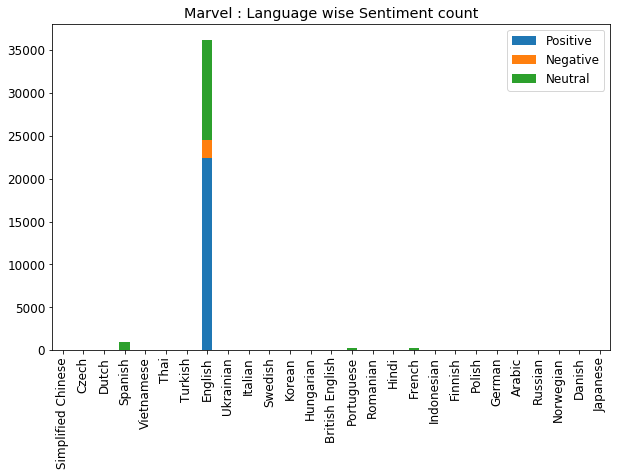

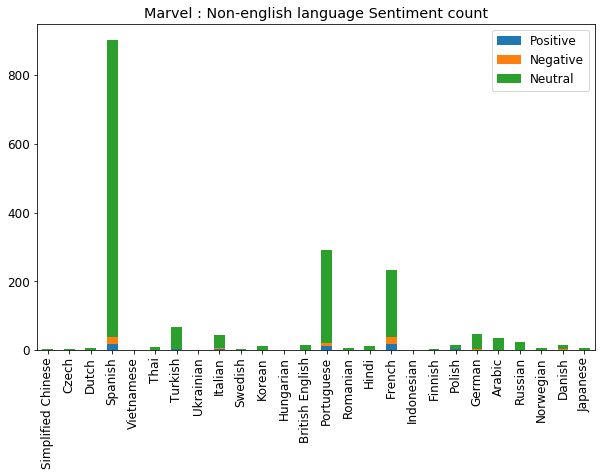

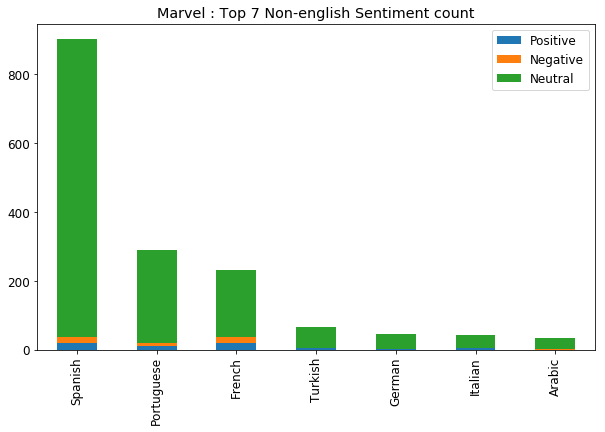

In [22]:
stack_mcu_df = format_df_for_me(mcu_df)                                            # for all languages
stack_mcu_df.plot.bar(stacked=True, title="Marvel : Language wise Sentiment count", figsize=(10,6))
stack_mcu_df = format_df_for_me(mcu_df.loc[:][mcu_df["language"] != "English"])    # for non-english language
stack_mcu_df.plot.bar(stacked=True, title="Marvel : Non-english language Sentiment count", figsize=(10,6))
stack_mcu_df = stack_mcu_df.sort_values(['Neutral'], ascending=[False])
stack_mcu_df = stack_mcu_df.iloc[:7][:]
stack_mcu_df.plot.bar(stacked=True, title="Marvel : Top 7 Non-english Sentiment count", figsize=(10,6))

<b> Analysis: </b> More than 20000 postive Marvel fan's tweets are in English language. And non-english language tweets are more neutral. Spanish Portuguese and Frech tweets are top 3 neutral tweets than English.

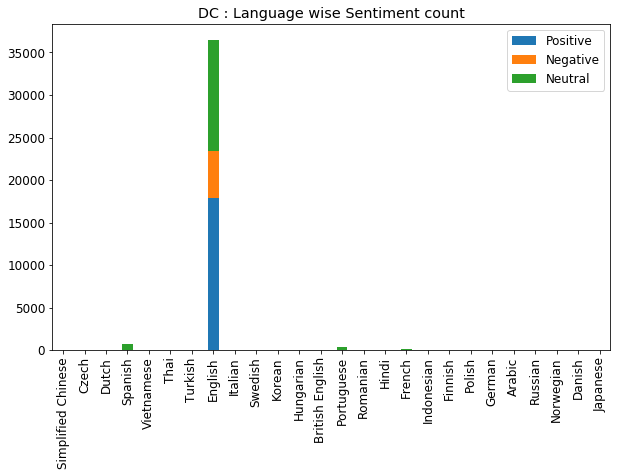

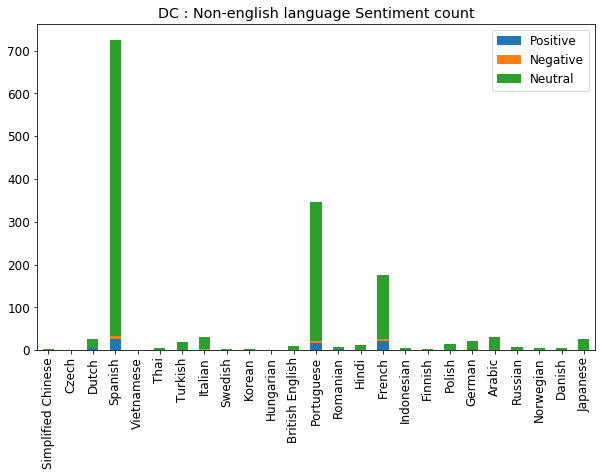

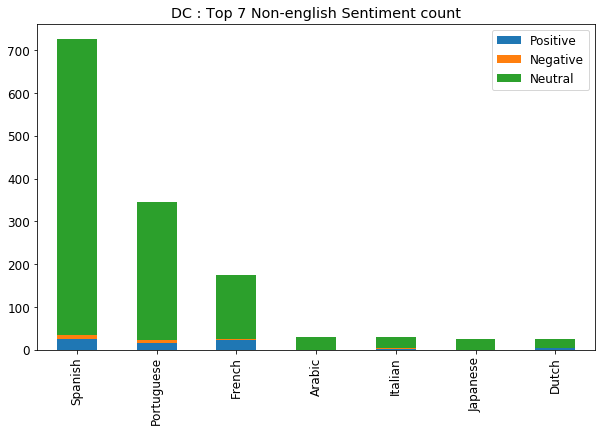

In [23]:
stack_dceu_df = format_df_for_me(dceu_df)                                            # for all languages
stack_dceu_df.plot.bar(stacked=True, title="DC : Language wise Sentiment count", figsize=(10,6))
stack_dceu_df = format_df_for_me(dceu_df.loc[:][dceu_df["language"] != "English"])    # for non-english language
stack_dceu_df.plot.bar(stacked=True, title="DC : Non-english language Sentiment count", figsize=(10,6))
stack_dceu_df = stack_dceu_df.sort_values(['Neutral'], ascending=[False])
stack_dceu_df = stack_dceu_df.iloc[:7][:]
stack_dceu_df.plot.bar(stacked=True, title="DC : Top 7 Non-english Sentiment count", figsize=(10,6))

<b> Analysis: </b> Likewise marvel tweets, most positive tweets related to DC are in English and most of the non-english tweets are neutral. But, for DC positve tweets are less than Marvel's positive tweets for english language

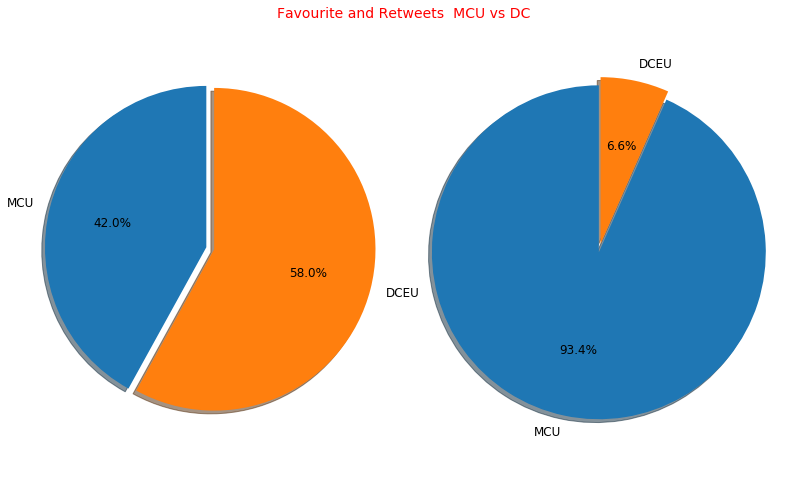

In [24]:
dceu_df["favorite_count"] = dceu_df["favorite_count"].astype("float64")
mcu_favorited_counts = mcu_df.loc[mcu_df["favorite_count"] >0]["favorite_count"].count()
dceu_favorited_counts = dceu_df.loc[dceu_df["favorite_count"] >0]["favorite_count"].count()

mcu_retweet_count = mcu_df.loc[mcu_df["retweet_count"] != 0, 'retweet_count'].sum()
dceu_retweet_count = dceu_df.loc[dceu_df["retweet_count"] != 0, 'retweet_count'].sum()

labels = ["MCU", "DCEU"]


matplotlib.rcParams['font.size'] = 12.0
explode = (0.0, 0.05) 

fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(11,7))
fig.suptitle("Favourite and Retweets  MCU vs DC", fontsize=14, color="red")

ax1.pie([mcu_favorited_counts, dceu_favorited_counts], explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  

ax2.pie([mcu_retweet_count,dceu_retweet_count], explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')  

plt.tight_layout()
plt.show()

<b> Analysis: </b> Marvel fan's retweeted more tweets than DC fan's. On the other hand, DC fan's liked the each other tweets more than Marvel fan's. As twitter data is 7 days old so latest release of Avenger Infinity war movie, caused to boost few tweet's retweet count in thousands. 
And it seems in this week Marvel fan's retweeted 10 times more than DC fan's. 

### Conclusion: 
From overall analysis we can conclude that,
- Most of the twitter user's are English language users and English language dominates the twitter dataset.
- In this week, Marvel fans retweeted more than DC fans.
- There are more Positive tweets by fans of Marvel than DC
- DC fans like each others tweet by favouriting it than Marvel

<b> Note: </b> <br>
Also I've worked on Dash library to show run time analysis of Twitter dataset.
- Please run twitter-data-generation.ipynb to create twitter live feeds (allow 1-2 mins to generate atleat 200 tweets)
- Please run twitter-live-graphs.ipynb to run the server. Click on the http://127.0.0.1:8050 once your server is started. Use 4 keywords to check the runtime sentiment analsis : "Marvel", "Avengers", "DCComics","BatmanvSuperman"